In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import scipy as sp
from scipy import signal


delta_freq = 2.5 * u.MHz
sample_interval = (1 / (2 * delta_freq)).to(u.s)

filename1 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant1_1420.0mhz__27.10.202315.13.26.grc"
filename2 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant2_1420.0mhz__27.10.202315.13.26.grc"


wrongdata = np.fromfile(filename1, dtype=np.complex64, count=200000, offset=0)
plt.plot(np.arange(len(wrongdata)) / (2.5*1e6), wrongdata)
plt.title("Raw data with artifact")
plt.xlabel("seconds")
plt.show()

#base offset is needed to filter out weird effect at the start of each signal
base_offset = 2**17 #in nr samples
print(f"Base offset is {base_offset / (2.5*1e6)} seconds")

#Take 0.1 seconds of antenna 1 and a small part of antenna 2 and correlate antenna 2 across antenna 1
rawdata1 = np.fromfile(filename1, dtype=np.complex64, count=200000, offset=base_offset*8)
rawdata2 = np.fromfile(filename2, dtype=np.complex64, count=100000, offset=base_offset*8)

plt.plot(np.arange(len(rawdata1)) / (2.5*1e6), rawdata1)
plt.title(f"Raw data example shifted by {base_offset / (2.5*1e6):.3f} seconds to remove artifact")
plt.xlabel("Seconds")
plt.show()


corr = signal.correlate(rawdata1, rawdata2, mode="valid") #mode valid means no zero padding at the beginning and end

plt.plot(signal.correlation_lags(len(rawdata1), len(rawdata2), mode="valid") / (2.5*1e6), np.real(corr))
plt.title("Real part of correlation")
plt.xlabel("Seconds")
plt.show()

plt.plot(signal.correlation_lags(len(rawdata1), len(rawdata2), mode="valid") / (2.5*1e6), np.imag(corr))
plt.title("Imaginary part of correlation")
plt.xlabel("Seconds")
plt.show()

plt.plot(signal.correlation_lags(len(rawdata1), len(rawdata2), mode="valid") / (2.5*1e6), np.real(corr)**2 + np.imag(corr)**2)
plt.title(f"Real(corr)$^2$ + Imag(corr)$^2$")
plt.xlabel("Seconds")
plt.show()


delay_samples = np.argmax(np.real(corr)**2 + np.imag(corr)**2)
print(f"Delay found (excluding base delay): {delay_samples} samples or {delay_samples /  (2.5*1e6)} seconds")


nrchan = int(2**16)
t = nrchan / (2.5*1e6)
print(f"FFT window: {nrchan} samples or {t} seconds")

#make the total number of samples a multiple of the size of the FFT window
nr_samples = int(5*(2.5*1e6) - 5*(2.5*1e6)%nrchan)

data1_5sec = np.fromfile(filename1, dtype=np.complex64, count=nr_samples, offset=base_offset*8 + delay_samples*8)
data2_5sec = np.fromfile(filename1, dtype=np.complex64, count=nr_samples, offset=base_offset*8)

data1_5sec = data1_5sec.reshape(int(nr_samples/nrchan), nrchan)
data2_5sec = data2_5sec.reshape(int(nr_samples/nrchan), nrchan)

FFT1 = np.fft.fft(data1_5sec, axis=1)
FFT2 = np.fft.fft(data2_5sec, axis=1)


plt.plot(np.fft.fftfreq(len(FFT1[0])), np.real(FFT1[0]))
plt.title("FFT of single window of data")
plt.show()

#remove the giant peak from the clock for better result
FFT1[:, -1] = 0
FFT2[:, -1] = 0

plt.plot(np.fft.fftfreq(len(FFT1[0])), np.real(FFT1[0]))
plt.title("Real part of FFT of data1 after removing clock peak")
plt.show()
plt.plot(np.fft.fftfreq(len(FFT1[0])), np.imag(FFT1[0]))
plt.title("Imaginary part of FFT of data1 after removing clock peak")
plt.show()
plt.plot(np.fft.fftfreq(len(FFT1[0])), np.real(FFT2[0]))
plt.title("Real part of FFT of data2 after removing clock peak")
plt.show()
plt.plot(np.fft.fftfreq(len(FFT1[0])), np.imag(FFT2[0]))
plt.title("Imaginary part of FFT of data2 after removing clock peak")
plt.show()



autocorrelation = np.mean(FFT1 * np.conj(FFT1), axis=0)
plt.plot(np.linspace(1420 - 1.25, 1420 + 1.25, len(autocorrelation)), np.real(autocorrelation))
plt.title("Autocorrelation test real (should be like assignment 1?)")
plt.show()
plt.plot(np.linspace(1420 - 1.25, 1420 + 1.25, len(autocorrelation)), np.imag(autocorrelation))
plt.title("Autocorrelation test imag (should be like assignment 1?)")
plt.show()


crosscorr = np.mean(FFT1 * np.conj(FFT2), axis=0)
plt.plot(np.linspace(1420 - 1.25, 1420 + 1.25, len(crosscorr)), np.real(crosscorr))
plt.title("Real part of cross correlation of FFTs averaged over 5 seconds")
plt.show()
plt.plot(np.linspace(1420 - 1.25, 1420 + 1.25, len(crosscorr)), np.imag(crosscorr))
plt.title("Imaginary part of cross correlation of FFTs averaged over 5 seconds")
plt.show()


result = np.fft.ifft(crosscorr)
plt.plot(np.fft.fftfreq(len(result)), np.real(result))
plt.title("Inverse FFT of cross correlation, real")
plt.show()
plt.plot(np.fft.fftfreq(len(result)), np.imag(result))
plt.title("Inverse FFT of cross correlation, imaginary")
plt.show()

Old code below, new code is the block above

In [1]:
import argparse

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import scipy as sp
from scipy import signal

In [2]:
delta_freq = 2.5 * u.MHz
sample_interval = (1 / (2 * delta_freq)).to(u.s)


# nrchan = 32768*8*8*2*8 #0.0131 seconds
nrchan = int(2**22/8)
t = nrchan / (2.5*1e6)
print(t, "seconds")

# filename1 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant1_1420.0mhz__27.10.202314.37.31.grc"
# filename2 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant2_1420.0mhz__27.10.202314.37.31.grc"
# filename3 = "/disks/strw2/RadioAstronomy2023/ant3_1420.0mhz__27.10.202314.37.28.grc"
# filename4 = "/disks/strw2/RadioAstronomy2023/ant4_1420.0mhz__27.10.202314.37.28.grc"
# filename5 = "/disks/strw2/RadioAstronomy2023/ant5_1420.0mhz__27.10.202314.37.26.grc"
# filename6 = "/disks/strw2/RadioAstronomy2023/ant6_1420.0mhz__27.10.202314.37.26.grc"
# filename7 = "/disks/strw2/RadioAstronomy2023/dataant7_1420.0mhz__27.10.202314.37.29.grc"
# filename8 = "/disks/strw2/RadioAstronomy2023/dataant8_1420.0mhz__27.10.202314.37.29.grc"


filename1 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant1_1420.0mhz__27.10.202315.13.26.grc"
filename2 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant2_1420.0mhz__27.10.202315.13.26.grc"
filename3 = "/disks/strw2/RadioAstronomy2023/ant3_1420.0mhz__27.10.202315.13.23.grc"
filename4 = "/disks/strw2/RadioAstronomy2023/ant4_1420.0mhz__27.10.202315.13.23.grc"
filename5 = "/disks/strw2/RadioAstronomy2023/ant5_1420.0mhz__27.10.202315.13.24.grc"
filename6 = "/disks/strw2/RadioAstronomy2023/ant6_1420.0mhz__27.10.202315.13.24.grc"
filename7 = "/disks/strw2/RadioAstronomy2023/dataant7_1420.0mhz__27.10.202315.13.25.grc"
filename8 = "/disks/strw2/RadioAstronomy2023/dataant8_1420.0mhz__27.10.202315.13.25.grc"

names = [filename1, filename2, filename3, filename4, filename5, filename6, filename7, filename8]

0.2097152 seconds


In [12]:
def find_correlate(file1, file2, offset):
    data1 = np.fromfile(file1, dtype=np.complex64, count=nrchan, offset=0)
    data2 = np.fromfile(file2, dtype=np.complex64, count=int(nrchan/2), offset=0 + offset)
    corr = signal.correlate(data1, data2)
    # plt.plot(np.arange(len(data1)), data1)
    # plt.plot(np.arange(len(data2)), data2)
    # plt.show()
    # plt.plot(signal.correlation_lags(len(data1), len(data2)), np.real(corr))
    # plt.show()
    return np.max(np.real(corr)) - np.min(np.real(corr))

def find_delay():
    values = []
    offsets = np.linspace(nrchan*0, nrchan*1, 1000, dtype=int)
    for offset in offsets:
        values.append(find_correlate(filename1, filename2, offset*8))
    plt.plot(offsets/(2.5*1e6), values)
    plt.xlabel("Offset in seconds")
    plt.ylabel("Max real value in correlation")
    plt.show()
    # return np.argmax(values)
    print(f"Offset is {offsets[np.argmax(values)]} values, thus {offsets[np.argmax(values)]*8} bytes")
    return offsets[np.argmax(values)]

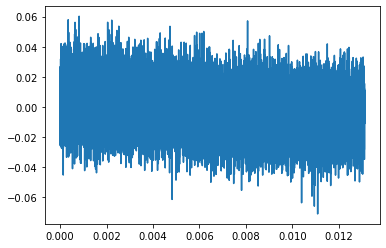

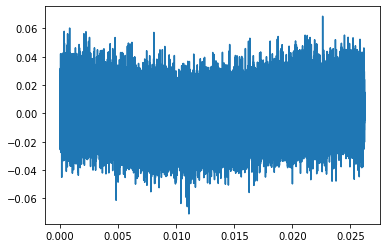

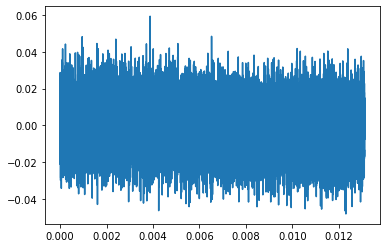

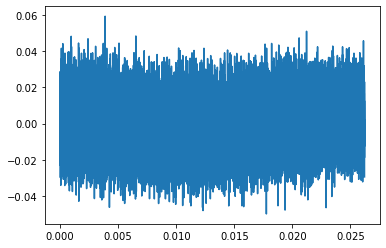

In [67]:
for name in names[:2]:
    data = np.fromfile(name, dtype=np.complex64, count=2**15, offset=2**15*8)
    plt.plot(np.arange(len(data)) / (2.5*1e6), np.real(data))
    plt.show()
    data = np.fromfile(name, dtype=np.complex64, count=int(nrchan/8), offset=2**15*8)
    plt.plot(np.arange(len(data)) / (2.5*1e6), np.real(data))
    plt.show()

(0, 1)
(1, 0)


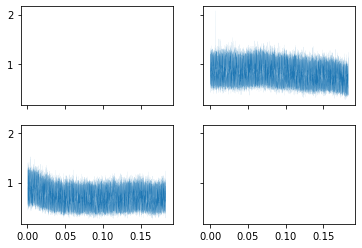

In [51]:
import itertools

indices = itertools.permutations(np.arange(2), 2)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for pair in indices:
    data1 = np.fromfile(names[pair[0]], dtype=np.complex64, count=nrchan, offset=nrchan*8)
    data2 = np.fromfile(names[pair[1]], dtype=np.complex64, count=int(nrchan/8), offset=nrchan*8)
    corr = signal.correlate(data1, data2, mode="valid")
    x = signal.correlation_lags(len(data1), len(data2), mode="valid") / (2.5*1e6)
    axs[pair[0], pair[1]].plot(x, np.real(corr)**2 + np.imag(corr)**2, linewidth=0.05)
    print(pair)

plt.savefig("correlations_real_valid", dpi=1000)
plt.show()


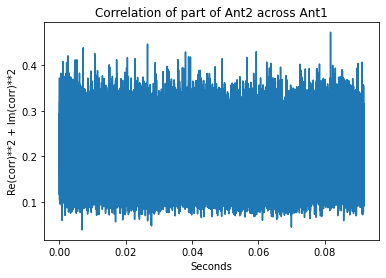

In [74]:
data1 = np.fromfile(names[0], dtype=np.complex64, count=int(2**16)*8, offset=2**18*8)
data2 = np.fromfile(names[1], dtype=np.complex64, count=int(2**16), offset=2**18*8)
corr = signal.correlate(data1, data2, mode="valid")
x = signal.correlation_lags(len(data1), len(data2), mode="valid") / (2.5*1e6)
plt.plot(x, np.real(corr)**2 + np.imag(corr)**2)
plt.xlabel("Seconds")
plt.ylabel("Re(corr)**2 + Im(corr)**2")
plt.title("Correlation of part of Ant2 across Ant1")
# plt.savefig("delay_correlation", dpi=500)
plt.show()

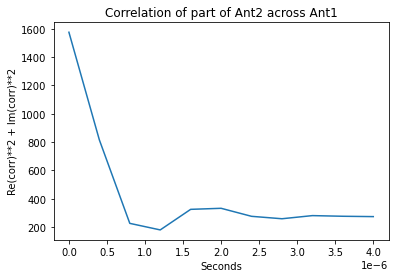

In [57]:
data1 = np.fromfile(names[0], dtype=np.complex64, count=int(nrchan*8) + 10, offset=nrchan*8*128 + nrchan*8*32 + nrchan*8*16 + delay_sample*8)
data2 = np.fromfile(names[1], dtype=np.complex64, count=int(nrchan*8), offset=nrchan*8*128 + nrchan*8*32 + nrchan*8*16)
corr = signal.correlate(data1, data2, mode="valid")
x = signal.correlation_lags(len(data1), len(data2), mode="valid") / (2.5*1e6)
plt.plot(x, np.real(corr)**2 + np.imag(corr)**2)
plt.xlabel("Seconds")
plt.ylabel("Re(corr)**2 + Im(corr)**2")
plt.title("Correlation of part of Ant2 across Ant1")
# plt.savefig("delay_correlation", dpi=500)
plt.show()

In [63]:
# delay_sample = np.argmax(np.real(corr)**2 + np.imag(corr)**2)
print((nrchan*8*128 + nrchan*8*32 + nrchan*8*16)/nrchan)
print((nrchan*8*128 + nrchan*8*32 + nrchan*8*16) / (2.5*1e6) / 8)

1408.0
36.9098752


In [7]:
find_delay()

SyntaxError: incomplete input (1803628914.py, line 1)

/usr/lib64/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


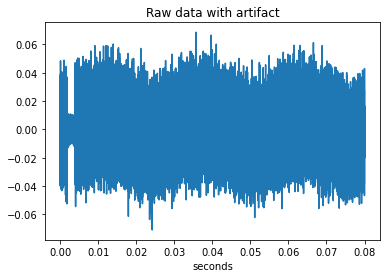

Base offset is 0.0524288 seconds


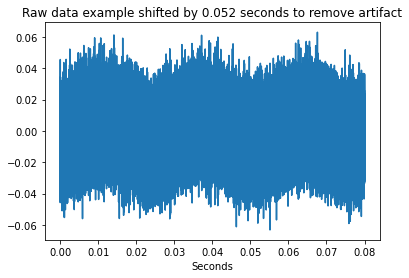

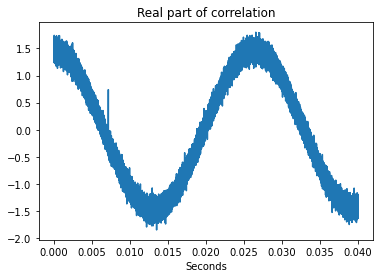

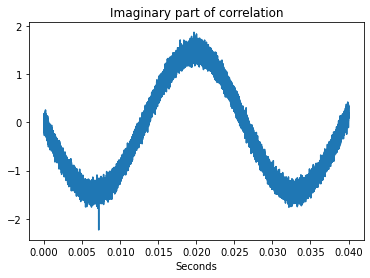

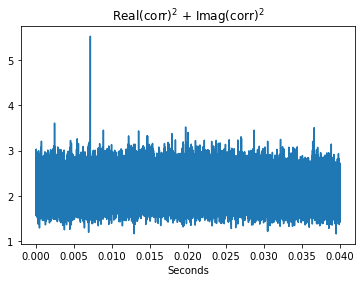

Delay found (excluding base delay): 17922 samples or 0.0071688 seconds
FFT window: 65536 samples or 0.0262144 seconds


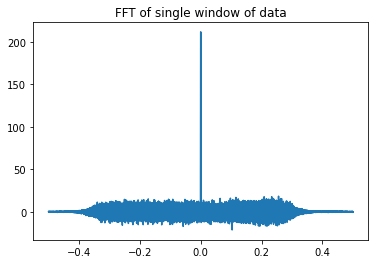

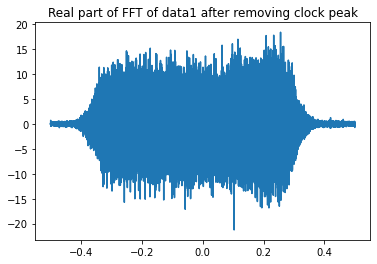

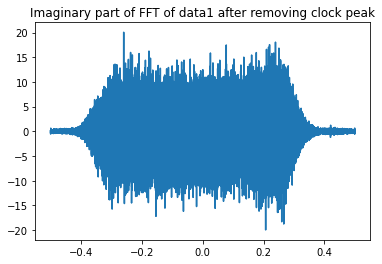

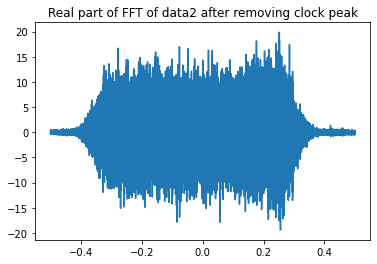

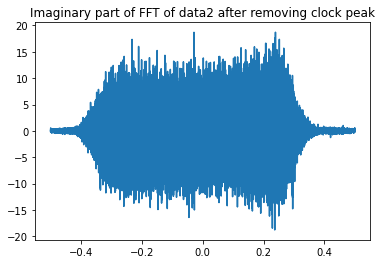

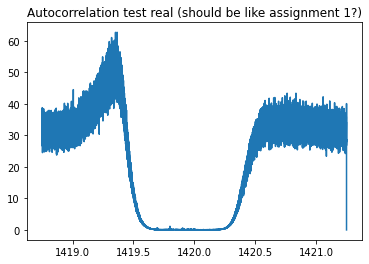

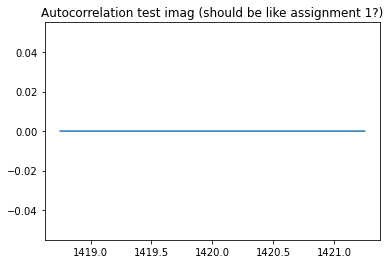

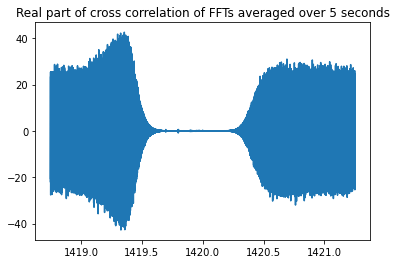

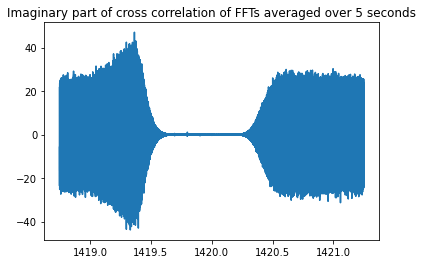

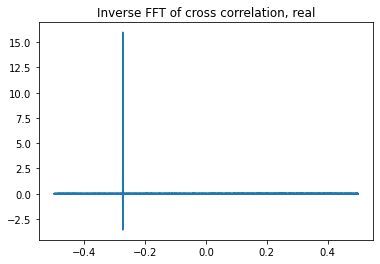

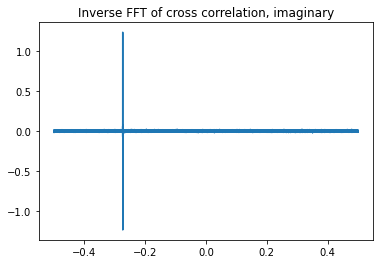

In [ ]:
def hdfig(subplots_def=None, scale=0.5):
    fig = plt.figure(figsize=(8, 4.5), dpi=scale * 1920 / 8)
    if subplots_def is None:
        return fig
    else:
        return fig, fig.subplots(*subplots_def)

def digitize(real_sequence: 'np.ndarray', nrbits: int = 8):
    result = np.rint(real_sequence).astype(int)
    maxpos = 2 ** (nrbits - 1) - 1
    maxneg = -(2 ** (nrbits - 1))
    result[result < maxneg] = maxneg
    result[result > maxpos] = maxpos
    return result


def simple_real_cross_power(ant_1_voltage, ant_2_voltage, nrbits: int = 4):
    # assert ant_1_voltage.shape == ant_2_voltage.shape
    s1 = ant_1_voltage #digitize(ant_1_voltage, nrbits=nrbits)
    s2 = ant_2_voltage #digitize(ant_2_voltage, nrbits=nrbits)
    return sp.signal.correlate(s1, s2, mode='same') / s1.shape[0]


def plot_real_xc(xc: 'np.ndarray[np.float]', width: int, sample_interval, caption=None):
    fig, ax = hdfig((1, 1))
    m = xc.shape[0] // 2
    lw = width // 2
    hw = width - lw
    delay = np.arange(-lw, hw) * sample_interval
    ax.plot(delay, xc[m - lw:m + hw])
    ax.set_xlabel('Delay [%s]' % delay.unit)
    if caption:
        ax.set_title(caption)
    plt.show()


def main():
    parser = argparse.ArgumentParser(description="calculating correlation as a in-field test",
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("file1", type=str, help="Name of file 1")
    parser.add_argument("file2", type=str, help="Name of file 2")
    parser.add_argument("-w", '--window', type=int, help="Window of correlation plot")
    args = parser.parse_args()
    config = vars(args)

    file1 = np.fromfile(config['file1'], dtype=np.complex64)  # [0:3000000]
    file2 = np.fromfile(config['file2'], dtype=np.complex64)  # [0:3000000]

    delta_freq = 2.5 * u.MHz
    sample_interval = (1 / (2 * delta_freq)).to(u.s)

    if config['window'] is None:
        w = 100000
    else:
        w = config['window']

    try:
        corrcoeff = np.corrcoef(file1, file2)[0, 1]
        cross = simple_real_cross_power(file1 * 10, file2 * 10, nrbits=4)
    except ValueError:
        lendiff = len(file2)-len(file1)
        print(f"Sample loss has occurred between the two, the difference in lenght is: {np.abs(lendiff)}")
        print(f"Calculating the correlation where the two are of equal length")
        if lendiff<0:
            file1 = file1[:lendiff]
        else:
            file2 = file2[:-lendiff]
        corrcoeff = np.corrcoef(file1, file2)[0, 1]
        cross = simple_real_cross_power(file1 * 10, file2 * 10, nrbits=4)


    print(f"The crosscorrelation coefficient of the data is: {np.real(corrcoeff):.3f}")

    plot_real_xc(cross, w, sample_interval)
